In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
TRAIN_PATH = '../Raw Data/Training Data/'
TEST_PATH = '../Raw Data/Test Data/'

In [4]:
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

In [6]:
test_image_paths = [glob.glob(join(TEST_PATH, test_id, "images", "*"))[0] for test_id in test_ids]

In [7]:
# changing the notebook to compare multiple images
np.random.seed(600)
tmp_image_paths = np.random.choice(test_image_paths,25)
tmp_images = [cv2.imread(tmp_image_path, cv2.IMREAD_GRAYSCALE) for tmp_image_path in tmp_image_paths]

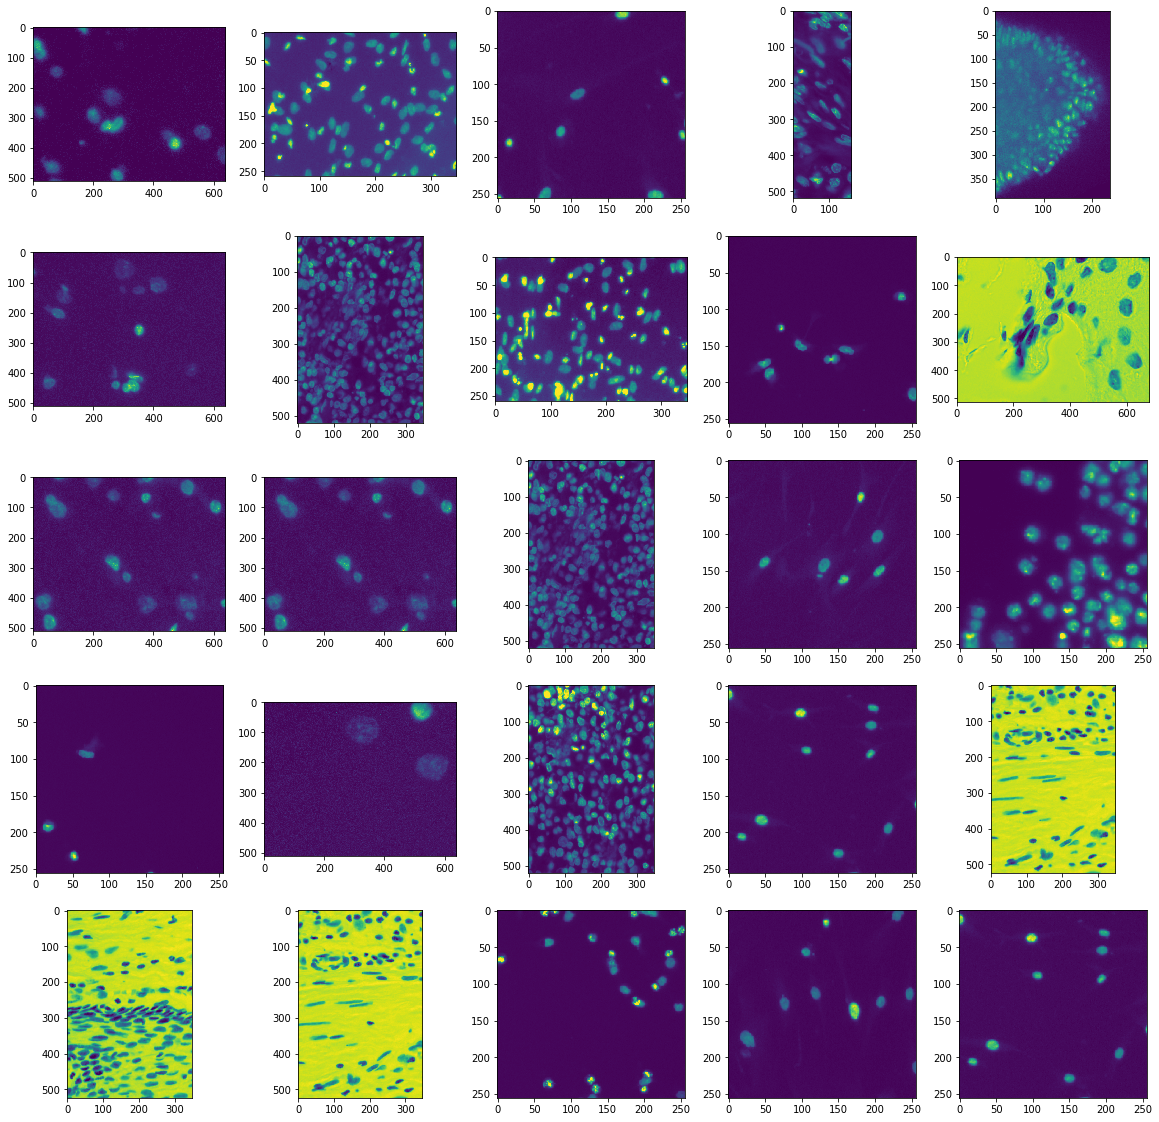

In [8]:
mfig, maxs = plt.subplots(5, 5, figsize = (20,20))
i = 0
j = 0
k = 0

for i in range(0,5):
    for j in range(0,5):
        maxs[i,j].imshow(tmp_images[k])
        k = k + 1

In [83]:
ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU)

TypeError: Required argument 'type' (pos 4) not found

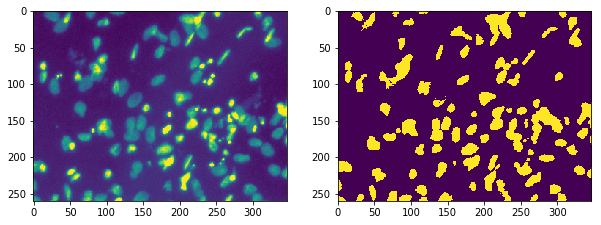

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)

In [15]:
_, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [19]:
max_cnt_area = cv2.contourArea(cnts[0])

In [25]:
print("The area of the largest object is: {0}".format(max_cnt_area))

The area of the largest object is: 910.5


In [28]:
if max_cnt_area > 50000:
    ret, thresh = cv2.threshold(tmp_image, 100, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

In [29]:
mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))

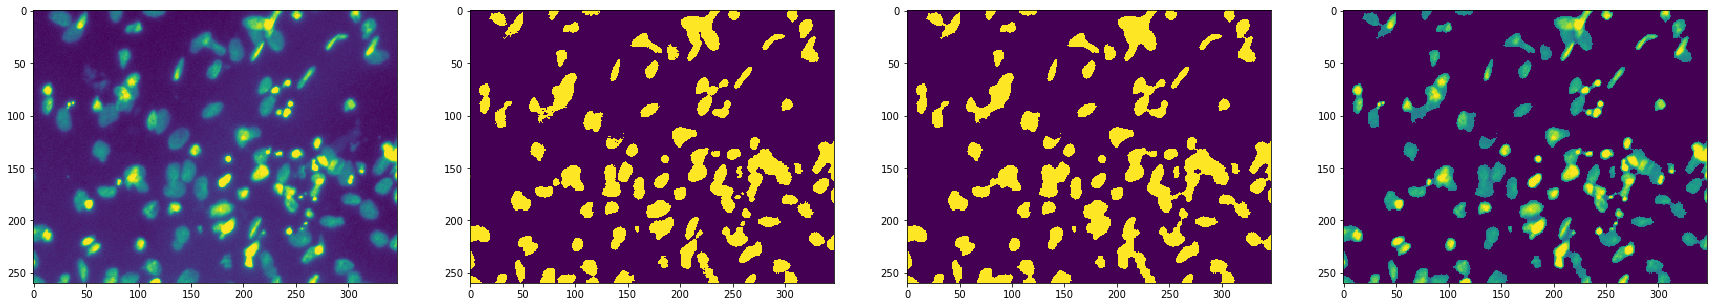

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(30,30))
axs[0].imshow(tmp_image)
axs[1].imshow(thresh)
axs[2].imshow(mask)
axs[3].imshow(cv2.bitwise_and(tmp_image, tmp_image, mask=mask))

In [31]:
def threshold(image_gray):
    image_gray = cv2.GaussianBlur(image_gray, (7, 7), 1)
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    
    _, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    return thresh

def apply_morphology(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    return mask

In [33]:
segmented = []
for test_image_path in test_image_paths:
    tmp_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    thresh = threshold(tmp_image)
    mask = apply_morphology(thresh)
    
    segmented.append(mask)

In [34]:
from skimage.morphology import label

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [35]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(segmented[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))